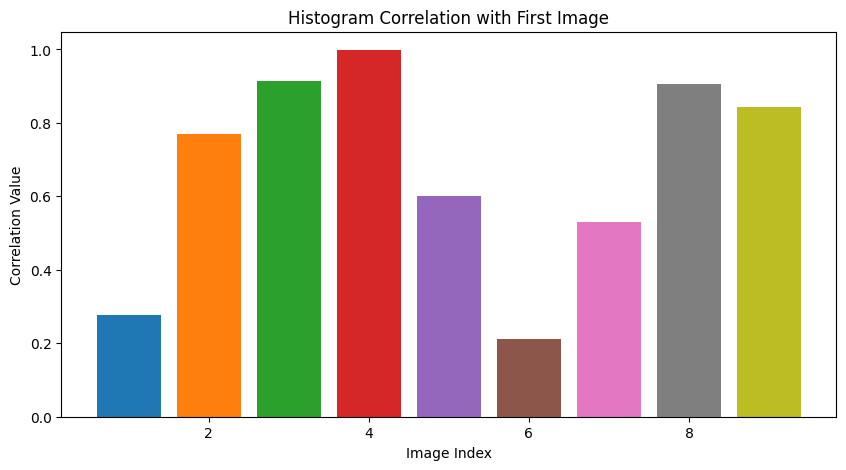

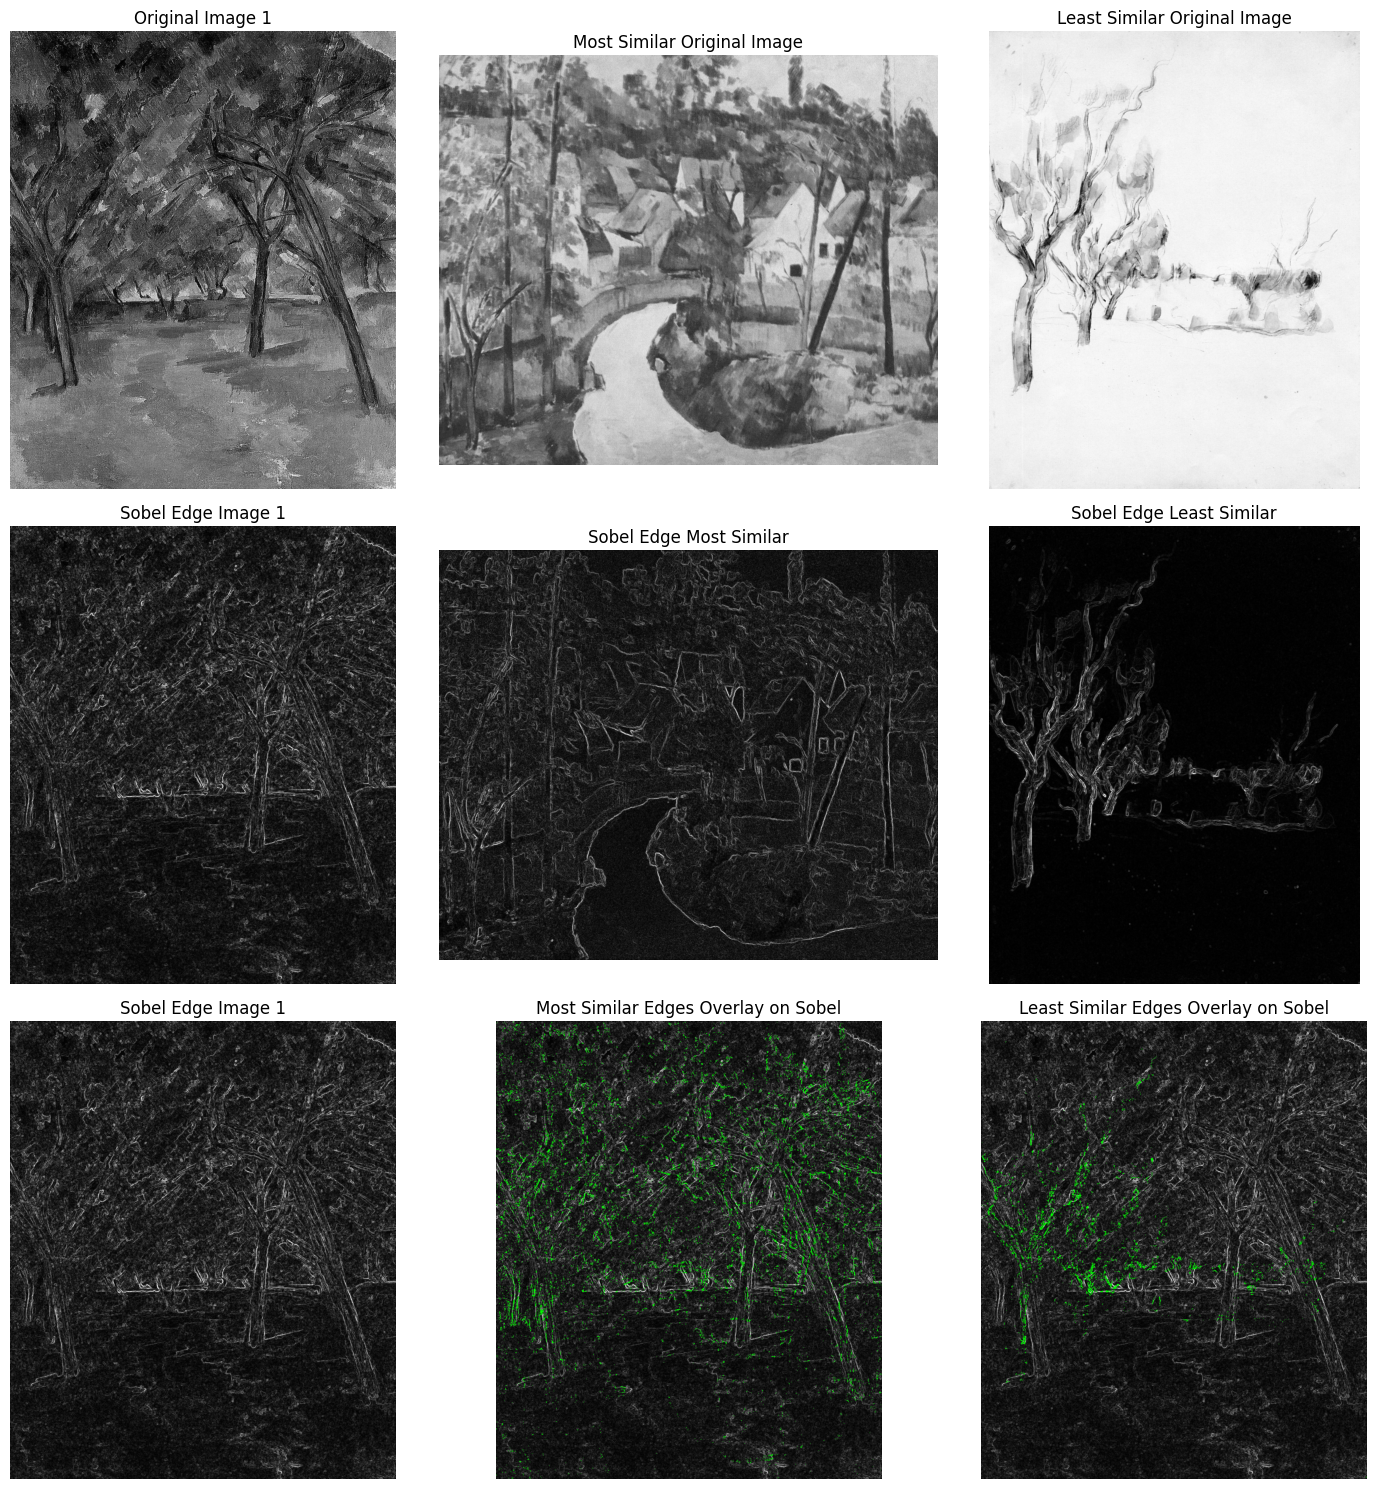

In [15]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile

def extract_images_from_zip(zip_path, extract_to_folder, limit=10):  # Default limit of 10
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
        extracted_files = zip_ref.namelist()
    # Ensure only the first 'limit' images are processed, if specified
    extracted_files = extracted_files[:limit] if limit is not None else extracted_files
    return [os.path.join(extract_to_folder, name) for name in extracted_files]

def apply_sobel(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read the image: {image_path}")
        return None, None
    
    # Apply Sobel edge detection on the X and Y axes
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate the absolute values of the Sobel derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Convert the absolute values to 8-bit images by normalizing
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    
    # Combine the scaled Sobel X and Y images to get the edge magnitude
    sobel_combined = cv2.bitwise_or(scaled_sobelx, scaled_sobely)
    
    return img, sobel_combined

def calculate_histogram(sobel_image):
    # Assuming a single-channel image, calculate its histogram
    hist = cv2.calcHist([sobel_image], [0], None, [256], [0, 256])
    return hist

def overlay_edges_on_original(original_img, base_edges, compare_edges, color):
    # Resize base and compare edges to match the original image size
    if base_edges.shape != original_img.shape[:2]:
        base_edges = cv2.resize(base_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    if compare_edges.shape != original_img.shape[:2]:
        compare_edges = cv2.resize(compare_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    
    # Convert to binary (0 or 255)
    _, base_edges_binary = cv2.threshold(base_edges, 50, 255, cv2.THRESH_BINARY)
    _, compare_edges_binary = cv2.threshold(compare_edges, 50, 255, cv2.THRESH_BINARY)

    # Find common edges
    common_edges = cv2.bitwise_and(base_edges_binary, compare_edges_binary)

    # Create a colored overlay of the common edges
    colored_edges_overlay = np.zeros_like(original_img, dtype=np.uint8)
    colored_edges_overlay[common_edges > 0] = color
    
    # Overlay the colored edges onto the original image
    overlay_img = original_img.copy()
    overlay_img[common_edges > 0] = color
    
    return overlay_img

def overlay_edges_on_sobel(sobel_base, sobel_compare, color):
    # Resize the compared Sobel image to match the base Sobel image
    sobel_compare = cv2.resize(sobel_compare, (sobel_base.shape[1], sobel_base.shape[0]), interpolation=cv2.INTER_AREA)

    # Convert to binary (0 or 255)
    _, sobel_base_binary = cv2.threshold(sobel_base, 50, 255, cv2.THRESH_BINARY)
    _, sobel_compare_binary = cv2.threshold(sobel_compare, 50, 255, cv2.THRESH_BINARY)
    
    # Find common edges
    common_edges = cv2.bitwise_and(sobel_base_binary, sobel_compare_binary)

    # Overlay the colored edges onto the Sobel edge detection
    sobel_colored_edges = cv2.cvtColor(sobel_base, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring

    # Create a mask where the common edges are
    mask = common_edges > 0

    # Assign the color to the mask in the BGR image
    sobel_colored_edges[mask] = color
    
    return sobel_colored_edges

zip_file_path = 'impressionist.zip'
extract_to_folder = 'impressionist_extracted'

# Extract images from the zip file
if not os.path.exists(extract_to_folder):
    os.makedirs(extract_to_folder)
    
image_paths = extract_images_from_zip(zip_file_path, extract_to_folder)
original_images = []
sobel_images = []
histograms = []

# Apply Sobel edge detection to each image and calculate histograms
for image_path in image_paths:
    original_img, sobel_image = apply_sobel(image_path)
    if sobel_image is not None:
        original_images.append(original_img)  # Keep the original images
        sobel_images.append(sobel_image)  # Keep the Sobel images for later processing
        histograms.append(calculate_histogram(sobel_image))  # Calculate histograms for correlation

# Calculate correlations and plot the histogram
correlations = []
if len(histograms) > 1:
    reference_histogram = histograms[0]
    for i, histogram in enumerate(histograms[1:], start=1):
        correlation = cv2.compareHist(reference_histogram, histogram, cv2.HISTCMP_CORREL)
        correlations.append(correlation)
else:
    print("Not enough valid histograms were generated for comparison.")
    raise SystemExit

# Plot the histogram after all histograms have been calculated
plt.figure(figsize=(10, 5))
for i, corr in enumerate(correlations, start=1):
    plt.bar(i, corr)
plt.title('Histogram Correlation with First Image')
plt.xlabel('Image Index')
plt.ylabel('Correlation Value')
plt.show()

# Identify the most and least correlated images
most_correlated_index = np.argmax(correlations) + 1  # +1 because the first histogram is the reference
least_correlated_index = np.argmin(correlations) + 1

# Generate overlays on the Sobel edge detection of the first original painting
overlay_most_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[most_correlated_index], [0, 255, 0])  # Green for most similar
overlay_least_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[least_correlated_index], [0, 255, 0])  # Red for least similar

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Three rows, three columns

# First row: First original image, most similar original image, least similar original image
axs[0, 0].imshow(cv2.cvtColor(original_images[0], cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(original_images[most_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Most Similar Original Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.cvtColor(original_images[least_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Least Similar Original Image')
axs[0, 2].axis('off')

# Second row: Sobel edge detections for the same images as first row
axs[1, 0].imshow(sobel_images[0], cmap='gray')
axs[1, 0].set_title('Sobel Edge Image 1')
axs[1, 0].axis('off')

axs[1, 1].imshow(sobel_images[most_correlated_index], cmap='gray')
axs[1, 1].set_title('Sobel Edge Most Similar')
axs[1, 1].axis('off')

axs[1, 2].imshow(sobel_images[least_correlated_index], cmap='gray')
axs[1, 2].set_title('Sobel Edge Least Similar')
axs[1, 2].axis('off')

# Third row: Overlay on Sobel images for the most and least similar images
# First column: Overlay of most similar edges on the first Sobel image

axs[2, 0].imshow(sobel_images[0], cmap='gray')
axs[2, 0].set_title('Sobel Edge Image 1')
axs[2, 0].axis('off')

axs[2, 1].imshow(overlay_most_on_sobel)
axs[2, 1].set_title('Most Similar Edges Overlay on Sobel')
axs[2, 1].axis('off')

# Second column: Overlay of least similar edges on the first Sobel image
axs[2, 2].imshow(overlay_least_on_sobel)
axs[2, 2].set_title('Least Similar Edges Overlay on Sobel')
axs[2, 2].axis('off')

# The third column in the last row should be empty as per the layout in the screenshot.
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()

Could not read the image: modrian_extracted/__MACOSX/._mondrian-1504681_1920.png
Could not read the image: modrian_extracted/__MACOSX/._Piet_Mondriaan_-_03.jpg
Could not read the image: modrian_extracted/__MACOSX/._Imagens-piet-mondrian-obras-e-biografia.webp
Could not read the image: modrian_extracted/__MACOSX/._images-1.png
Could not read the image: modrian_extracted/__MACOSX/._images-2.png


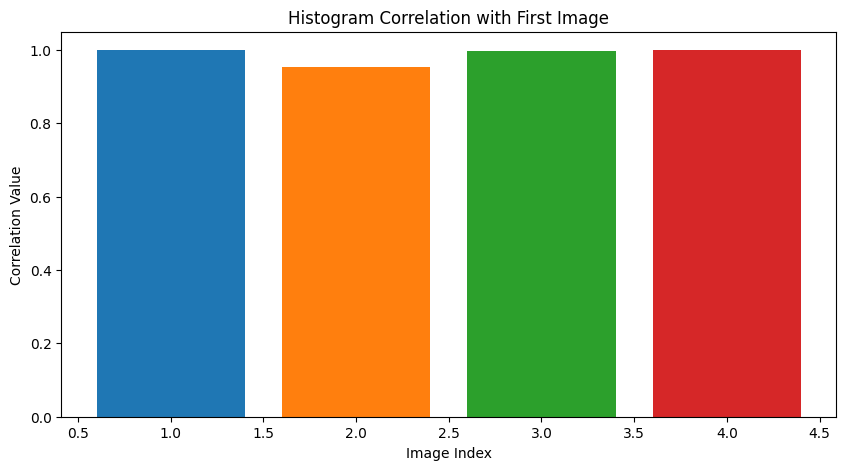

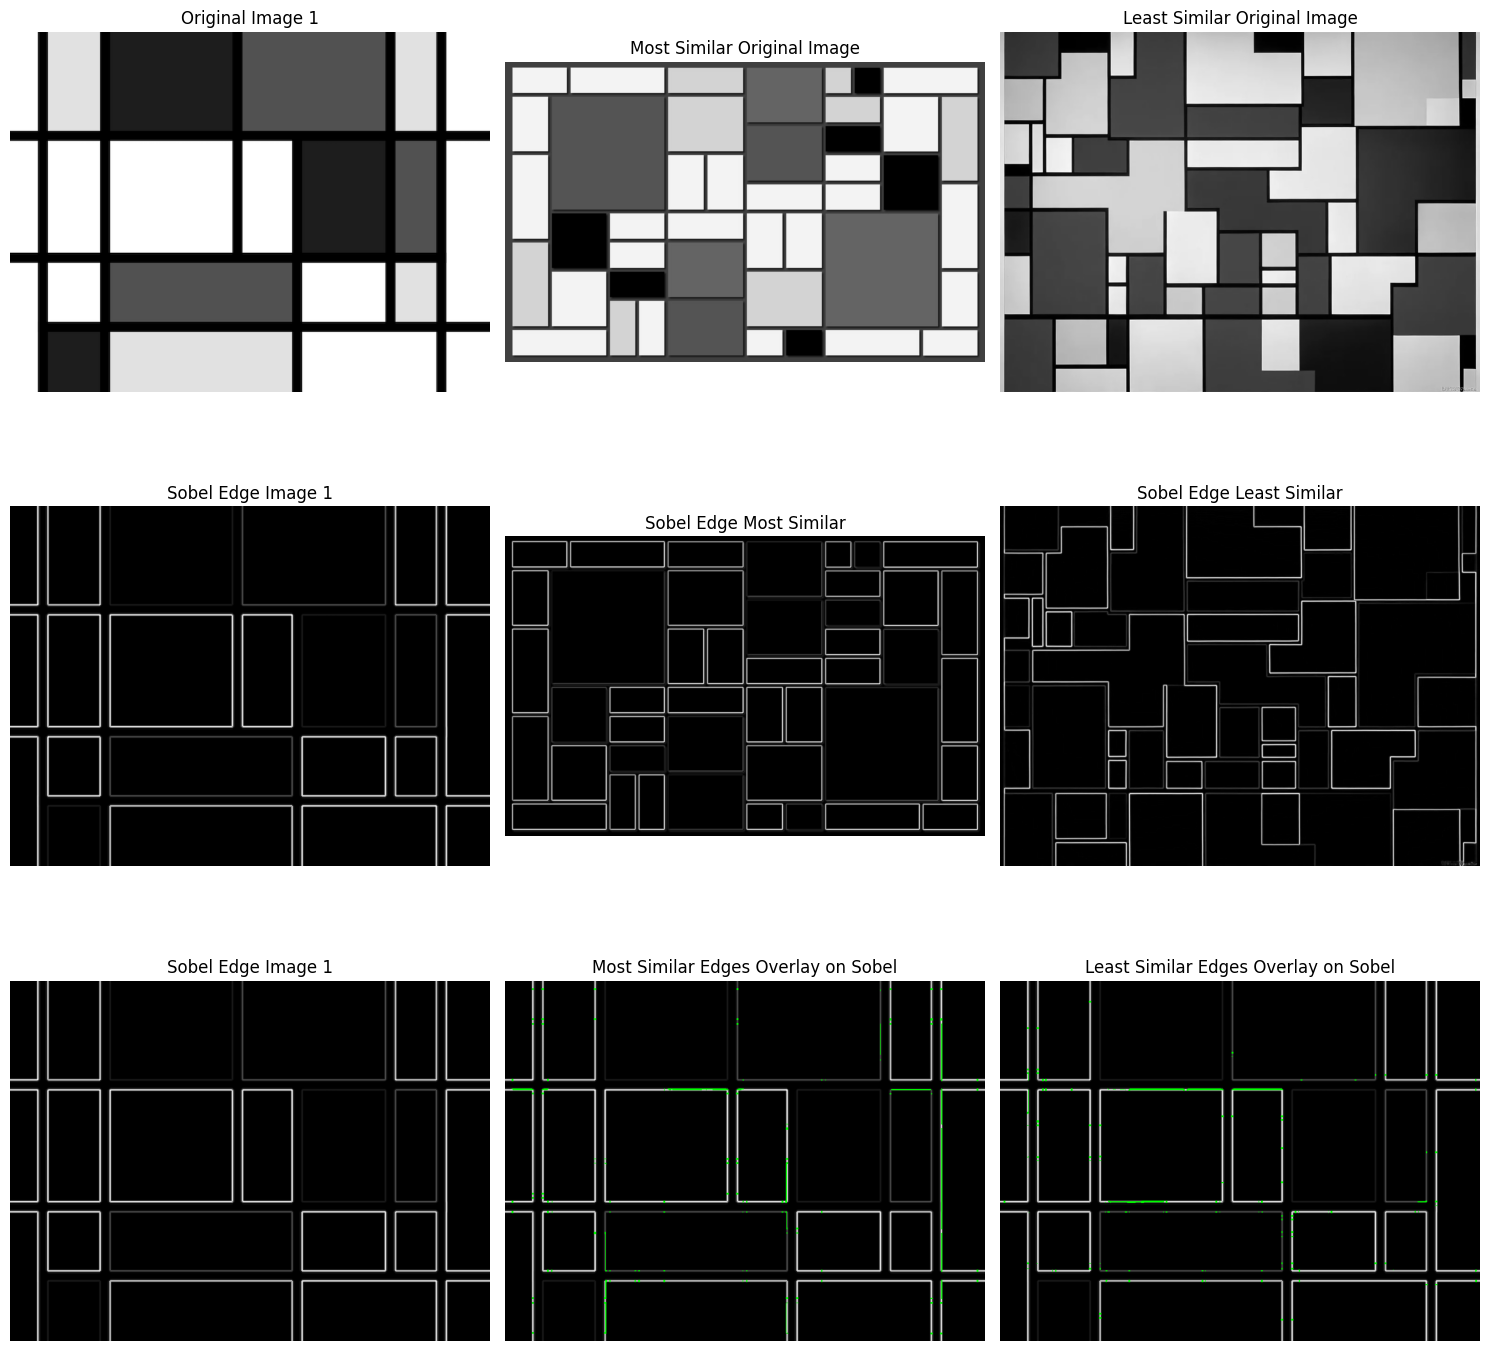

In [19]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile

def extract_images_from_zip(zip_path, extract_to_folder, limit=10):  # Default limit of 10
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
        extracted_files = zip_ref.namelist()
    # Ensure only the first 'limit' images are processed, if specified
    extracted_files = extracted_files[:limit] if limit is not None else extracted_files
    return [os.path.join(extract_to_folder, name) for name in extracted_files]

def apply_sobel(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read the image: {image_path}")
        return None, None
    
    # Apply Sobel edge detection on the X and Y axes
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate the absolute values of the Sobel derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Convert the absolute values to 8-bit images by normalizing
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    
    # Combine the scaled Sobel X and Y images to get the edge magnitude
    sobel_combined = cv2.bitwise_or(scaled_sobelx, scaled_sobely)
    
    return img, sobel_combined

def calculate_histogram(sobel_image):
    # Assuming a single-channel image, calculate its histogram
    hist = cv2.calcHist([sobel_image], [0], None, [256], [0, 256])
    return hist

def overlay_edges_on_original(original_img, base_edges, compare_edges, color):
    # Resize base and compare edges to match the original image size
    if base_edges.shape != original_img.shape[:2]:
        base_edges = cv2.resize(base_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    if compare_edges.shape != original_img.shape[:2]:
        compare_edges = cv2.resize(compare_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    
    # Convert to binary (0 or 255)
    _, base_edges_binary = cv2.threshold(base_edges, 50, 255, cv2.THRESH_BINARY)
    _, compare_edges_binary = cv2.threshold(compare_edges, 50, 255, cv2.THRESH_BINARY)

    # Find common edges
    common_edges = cv2.bitwise_and(base_edges_binary, compare_edges_binary)

    # Create a colored overlay of the common edges
    colored_edges_overlay = np.zeros_like(original_img, dtype=np.uint8)
    colored_edges_overlay[common_edges > 0] = color
    
    # Overlay the colored edges onto the original image
    overlay_img = original_img.copy()
    overlay_img[common_edges > 0] = color
    
    return overlay_img

def overlay_edges_on_sobel(sobel_base, sobel_compare, color):
    # Resize the compared Sobel image to match the base Sobel image
    sobel_compare = cv2.resize(sobel_compare, (sobel_base.shape[1], sobel_base.shape[0]), interpolation=cv2.INTER_AREA)

    # Convert to binary (0 or 255)
    _, sobel_base_binary = cv2.threshold(sobel_base, 50, 255, cv2.THRESH_BINARY)
    _, sobel_compare_binary = cv2.threshold(sobel_compare, 50, 255, cv2.THRESH_BINARY)
    
    # Find common edges
    common_edges = cv2.bitwise_and(sobel_base_binary, sobel_compare_binary)

    # Overlay the colored edges onto the Sobel edge detection
    sobel_colored_edges = cv2.cvtColor(sobel_base, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring

    # Create a mask where the common edges are
    mask = common_edges > 0

    # Assign the color to the mask in the BGR image
    sobel_colored_edges[mask] = color
    
    return sobel_colored_edges

zip_file_path = 'modrian.zip'
extract_to_folder = 'modrian_extracted'

# Extract images from the zip file
if not os.path.exists(extract_to_folder):
    os.makedirs(extract_to_folder)
    
image_paths = extract_images_from_zip(zip_file_path, extract_to_folder)
original_images = []
sobel_images = []
histograms = []

# Apply Sobel edge detection to each image and calculate histograms
for image_path in image_paths:
    original_img, sobel_image = apply_sobel(image_path)
    if sobel_image is not None:
        original_images.append(original_img)  # Keep the original images
        sobel_images.append(sobel_image)  # Keep the Sobel images for later processing
        histograms.append(calculate_histogram(sobel_image))  # Calculate histograms for correlation

# Calculate correlations and plot the histogram
correlations = []
if len(histograms) > 1:
    reference_histogram = histograms[0]
    for i, histogram in enumerate(histograms[1:], start=1):
        correlation = cv2.compareHist(reference_histogram, histogram, cv2.HISTCMP_CORREL)
        correlations.append(correlation)
else:
    print("Not enough valid histograms were generated for comparison.")
    raise SystemExit

# Plot the histogram after all histograms have been calculated
plt.figure(figsize=(10, 5))
for i, corr in enumerate(correlations, start=1):
    plt.bar(i, corr)
plt.title('Histogram Correlation with First Image')
plt.xlabel('Image Index')
plt.ylabel('Correlation Value')
plt.show()

# Identify the most and least correlated images
most_correlated_index = np.argmax(correlations) + 1  # +1 because the first histogram is the reference
least_correlated_index = np.argmin(correlations) + 1

# Generate overlays on the Sobel edge detection of the first original painting
overlay_most_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[most_correlated_index], [0, 255, 0])  # Green for most similar
overlay_least_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[least_correlated_index], [0, 255, 0])  # Red for least similar

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Three rows, three columns

# First row: First original image, most similar original image, least similar original image
axs[0, 0].imshow(cv2.cvtColor(original_images[0], cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(original_images[most_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Most Similar Original Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.cvtColor(original_images[least_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Least Similar Original Image')
axs[0, 2].axis('off')

# Second row: Sobel edge detections for the same images as first row
axs[1, 0].imshow(sobel_images[0], cmap='gray')
axs[1, 0].set_title('Sobel Edge Image 1')
axs[1, 0].axis('off')

axs[1, 1].imshow(sobel_images[most_correlated_index], cmap='gray')
axs[1, 1].set_title('Sobel Edge Most Similar')
axs[1, 1].axis('off')

axs[1, 2].imshow(sobel_images[least_correlated_index], cmap='gray')
axs[1, 2].set_title('Sobel Edge Least Similar')
axs[1, 2].axis('off')

# Third row: Overlay on Sobel images for the most and least similar images
# First column: Overlay of most similar edges on the first Sobel image

axs[2, 0].imshow(sobel_images[0], cmap='gray')
axs[2, 0].set_title('Sobel Edge Image 1')
axs[2, 0].axis('off')

axs[2, 1].imshow(overlay_most_on_sobel)
axs[2, 1].set_title('Most Similar Edges Overlay on Sobel')
axs[2, 1].axis('off')

# Second column: Overlay of least similar edges on the first Sobel image
axs[2, 2].imshow(overlay_least_on_sobel)
axs[2, 2].set_title('Least Similar Edges Overlay on Sobel')
axs[2, 2].axis('off')

# The third column in the last row should be empty as per the layout in the screenshot.
axs[2, 2].axis('off')

plt.tight_layout()
plt.show() 

Could not read the image: cuban_extracted/paintings/.ipynb_checkpoints/Data Clean-checkpoint.ipynb


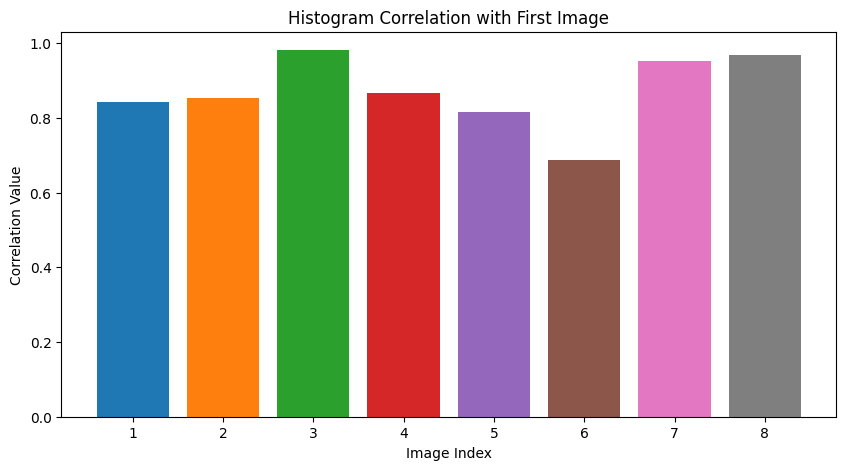

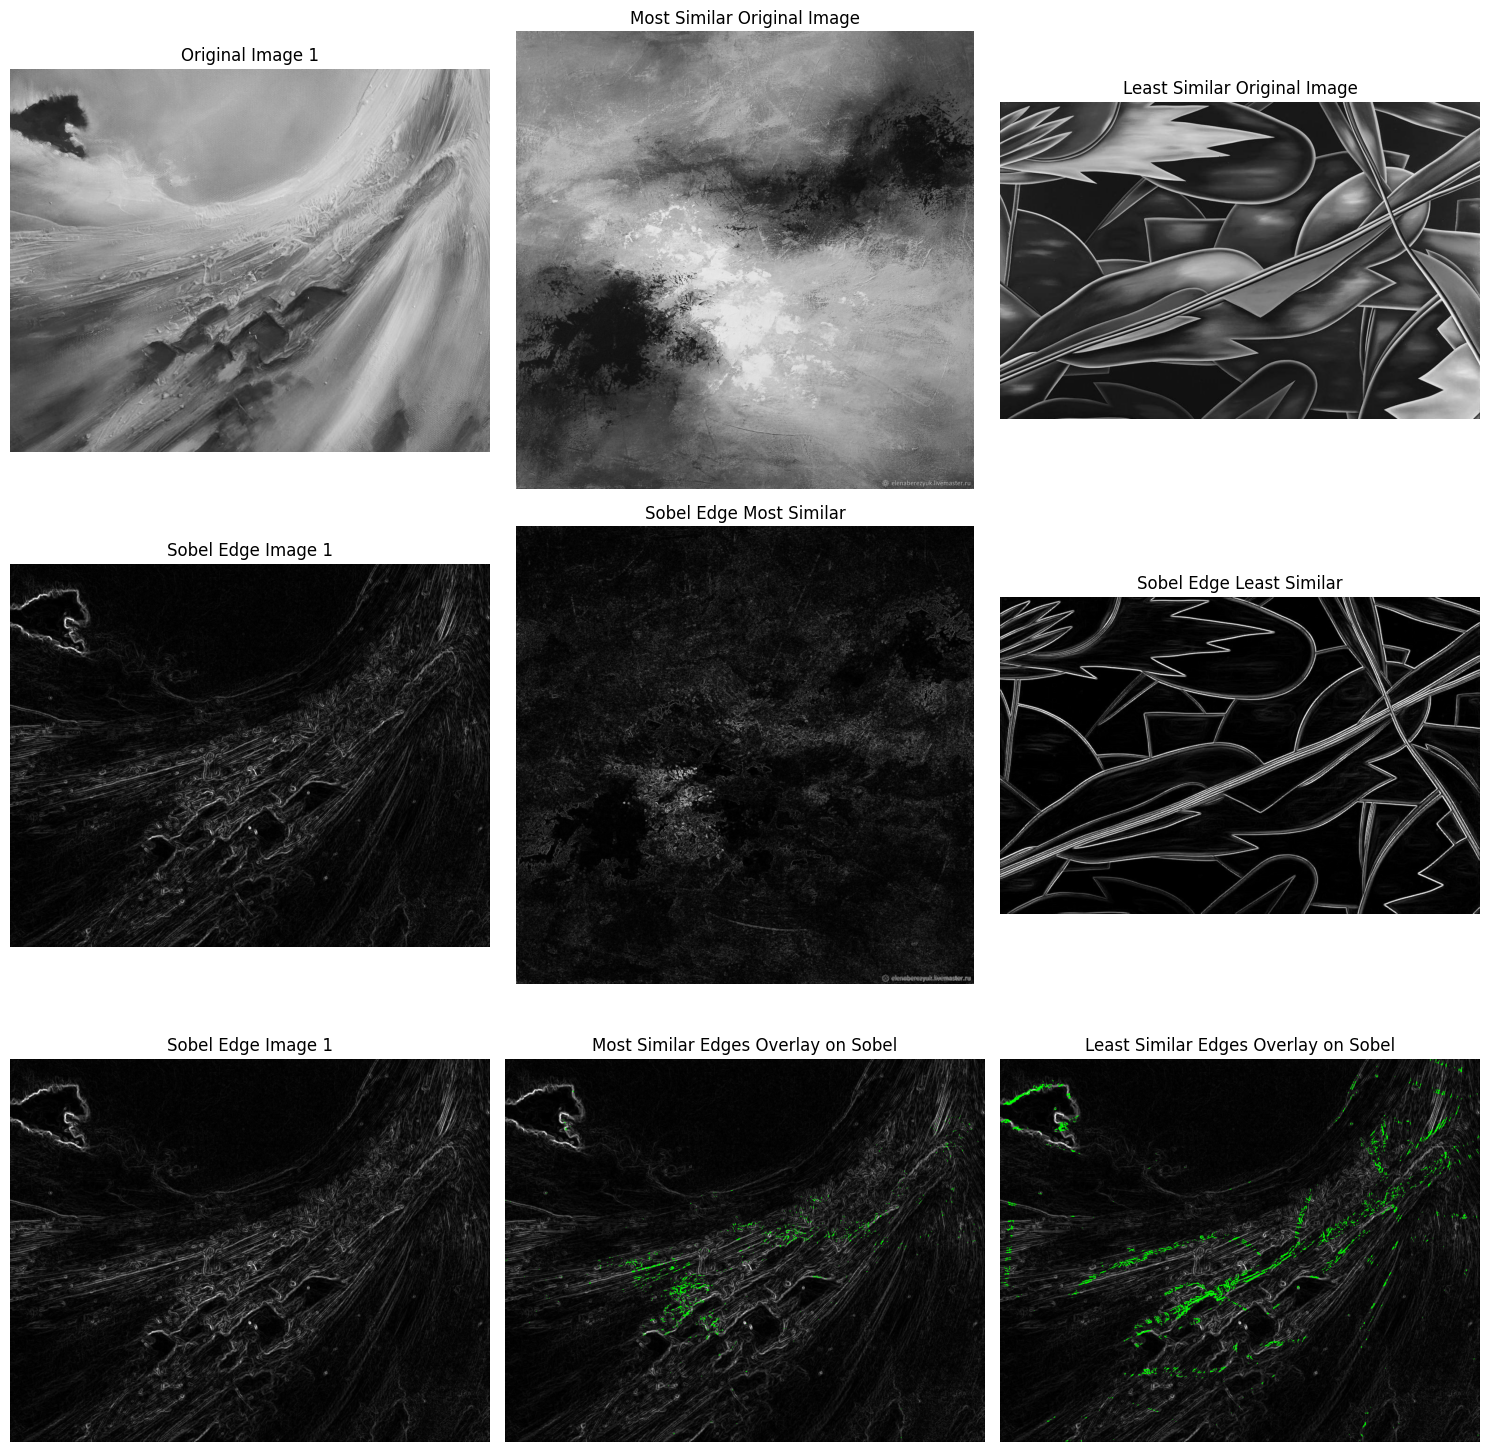

In [20]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile

def extract_images_from_zip(zip_path, extract_to_folder, limit=10):  # Default limit of 10
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
        extracted_files = zip_ref.namelist()
    # Ensure only the first 'limit' images are processed, if specified
    extracted_files = extracted_files[:limit] if limit is not None else extracted_files
    return [os.path.join(extract_to_folder, name) for name in extracted_files]

def apply_sobel(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read the image: {image_path}")
        return None, None
    
    # Apply Sobel edge detection on the X and Y axes
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate the absolute values of the Sobel derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Convert the absolute values to 8-bit images by normalizing
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    
    # Combine the scaled Sobel X and Y images to get the edge magnitude
    sobel_combined = cv2.bitwise_or(scaled_sobelx, scaled_sobely)
    
    return img, sobel_combined

def calculate_histogram(sobel_image):
    # Assuming a single-channel image, calculate its histogram
    hist = cv2.calcHist([sobel_image], [0], None, [256], [0, 256])
    return hist

def overlay_edges_on_original(original_img, base_edges, compare_edges, color):
    # Resize base and compare edges to match the original image size
    if base_edges.shape != original_img.shape[:2]:
        base_edges = cv2.resize(base_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    if compare_edges.shape != original_img.shape[:2]:
        compare_edges = cv2.resize(compare_edges, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)
    
    # Convert to binary (0 or 255)
    _, base_edges_binary = cv2.threshold(base_edges, 50, 255, cv2.THRESH_BINARY)
    _, compare_edges_binary = cv2.threshold(compare_edges, 50, 255, cv2.THRESH_BINARY)

    # Find common edges
    common_edges = cv2.bitwise_and(base_edges_binary, compare_edges_binary)

    # Create a colored overlay of the common edges
    colored_edges_overlay = np.zeros_like(original_img, dtype=np.uint8)
    colored_edges_overlay[common_edges > 0] = color
    
    # Overlay the colored edges onto the original image
    overlay_img = original_img.copy()
    overlay_img[common_edges > 0] = color
    
    return overlay_img

def overlay_edges_on_sobel(sobel_base, sobel_compare, color):
    # Resize the compared Sobel image to match the base Sobel image
    sobel_compare = cv2.resize(sobel_compare, (sobel_base.shape[1], sobel_base.shape[0]), interpolation=cv2.INTER_AREA)

    # Convert to binary (0 or 255)
    _, sobel_base_binary = cv2.threshold(sobel_base, 50, 255, cv2.THRESH_BINARY)
    _, sobel_compare_binary = cv2.threshold(sobel_compare, 50, 255, cv2.THRESH_BINARY)
    
    # Find common edges
    common_edges = cv2.bitwise_and(sobel_base_binary, sobel_compare_binary)

    # Overlay the colored edges onto the Sobel edge detection
    sobel_colored_edges = cv2.cvtColor(sobel_base, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring

    # Create a mask where the common edges are
    mask = common_edges > 0

    # Assign the color to the mask in the BGR image
    sobel_colored_edges[mask] = color
    
    return sobel_colored_edges

zip_file_path = 'cuban.zip'
extract_to_folder = 'cuban_extracted'

# Extract images from the zip file
if not os.path.exists(extract_to_folder):
    os.makedirs(extract_to_folder)
    
image_paths = extract_images_from_zip(zip_file_path, extract_to_folder)
original_images = []
sobel_images = []
histograms = []

# Apply Sobel edge detection to each image and calculate histograms
for image_path in image_paths:
    original_img, sobel_image = apply_sobel(image_path)
    if sobel_image is not None:
        original_images.append(original_img)  # Keep the original images
        sobel_images.append(sobel_image)  # Keep the Sobel images for later processing
        histograms.append(calculate_histogram(sobel_image))  # Calculate histograms for correlation

# Calculate correlations and plot the histogram
correlations = []
if len(histograms) > 1:
    reference_histogram = histograms[0]
    for i, histogram in enumerate(histograms[1:], start=1):
        correlation = cv2.compareHist(reference_histogram, histogram, cv2.HISTCMP_CORREL)
        correlations.append(correlation)
else:
    print("Not enough valid histograms were generated for comparison.")
    raise SystemExit

# Plot the histogram after all histograms have been calculated
plt.figure(figsize=(10, 5))
for i, corr in enumerate(correlations, start=1):
    plt.bar(i, corr)
plt.title('Histogram Correlation with First Image')
plt.xlabel('Image Index')
plt.ylabel('Correlation Value')
plt.show()

# Identify the most and least correlated images
most_correlated_index = np.argmax(correlations) + 1  # +1 because the first histogram is the reference
least_correlated_index = np.argmin(correlations) + 1

# Generate overlays on the Sobel edge detection of the first original painting
overlay_most_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[most_correlated_index], [0, 255, 0])  # Green for most similar
overlay_least_on_sobel = overlay_edges_on_sobel(sobel_images[0], sobel_images[least_correlated_index], [0, 255, 0])  # Red for least similar

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Three rows, three columns

# First row: First original image, most similar original image, least similar original image
axs[0, 0].imshow(cv2.cvtColor(original_images[0], cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(original_images[most_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Most Similar Original Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.cvtColor(original_images[least_correlated_index], cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Least Similar Original Image')
axs[0, 2].axis('off')

# Second row: Sobel edge detections for the same images as first row
axs[1, 0].imshow(sobel_images[0], cmap='gray')
axs[1, 0].set_title('Sobel Edge Image 1')
axs[1, 0].axis('off')

axs[1, 1].imshow(sobel_images[most_correlated_index], cmap='gray')
axs[1, 1].set_title('Sobel Edge Most Similar')
axs[1, 1].axis('off')

axs[1, 2].imshow(sobel_images[least_correlated_index], cmap='gray')
axs[1, 2].set_title('Sobel Edge Least Similar')
axs[1, 2].axis('off')

# Third row: Overlay on Sobel images for the most and least similar images
# First column: Overlay of most similar edges on the first Sobel image

axs[2, 0].imshow(sobel_images[0], cmap='gray')
axs[2, 0].set_title('Sobel Edge Image 1')
axs[2, 0].axis('off')

axs[2, 1].imshow(overlay_most_on_sobel)
axs[2, 1].set_title('Most Similar Edges Overlay on Sobel')
axs[2, 1].axis('off')

# Second column: Overlay of least similar edges on the first Sobel image
axs[2, 2].imshow(overlay_least_on_sobel)
axs[2, 2].set_title('Least Similar Edges Overlay on Sobel')
axs[2, 2].axis('off')

# The third column in the last row should be empty as per the layout in the screenshot.
axs[2, 2].axis('off')

plt.tight_layout()
plt.show() 